In [1]:
import xarray as xr
from scipy.interpolate import griddata
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from metpy.calc import geopotential_to_height
from scipy.interpolate import RegularGridInterpolator
from metpy.units import units

### must correct in separate steps
### 1. Obtain the tem_diff1 between sea level and geometric height
### 2. Traverse the era5 data before interpolation and add the tem_diff1 to the data at each time point
### 3. Traverse the era5 data and perform bilinear interpolation
### 4. Interpolate the elevation and calculate the tem_diff2 between sea level and 
### 5. Traverse the interpolated ERA5 and subtract tem_diff2 from the data at each time point

In [7]:
pip install netCDF4 rasterio rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.0/443.0 kB 10.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Users/wangy/Documents/MACS/Thesis/thesis_code/thesis_featurevisual/venv/bin/pytho

In [2]:
city = "Charleroi"

### This part is to interpolate geopotential height into ERA5 coordinates

In [3]:
geo_ds = xr.open_dataset(f'/Users/wangy/Documents/MACS/Thesis/ERA5_variables/{city}/geopot_{city}_UrbClim_2015_01_v1.0.nc')
geo_df = geo_ds.to_dataframe().reset_index()
geo_df = geo_df[['y','x','z']]
geo_df = geo_df.rename(columns={'z': 'geopot_height'})
print(geo_df)

era5_ds = xr.open_dataset('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/ERA5_2016_07.nc')
urbclim_coor = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/UrbClim_data/{city}/{city}_urbclim_coordinates.csv', index_col=0)

               y         x  geopot_height
0      50.513763  4.287202    1182.509766
1      50.513763  4.288345    1182.509766
2      50.513763  4.289489    1182.509766
3      50.513763  4.290632    1182.509766
4      50.513763  4.291775    1182.509766
...          ...       ...            ...
45045  50.320549  4.584454    2014.001953
45046  50.320549  4.585598    2014.001953
45047  50.320549  4.586741    2014.001953
45048  50.320549  4.587884    2014.001953
45049  50.320549  4.589028    2014.001953

[45050 rows x 3 columns]


In [4]:
# Select the latitude and longitude range
lat_min = urbclim_coor['y'].min() - 1
lat_max = urbclim_coor['y'].max() + 1
lon_min = urbclim_coor['x'].min() - 1 
lon_max = urbclim_coor['x'].max() + 1


lon_range = (era5_ds.variables['longitude'][:] >= lon_min) & (era5_ds.variables['longitude'][:] <= lon_max)
lat_range = (era5_ds.variables['latitude'][:] >= lat_min) & (era5_ds.variables['latitude'][:] <= lat_max)

In [7]:
# Cut out the Brussels ERA5 from the whole ERA5 data

era5_2015_07_df = pd.DataFrame()
# ds = ds[['t2m']]

# Iterate over all variables
for var_name in era5_ds.data_vars:
    # Extract region data
    var_region = era5_ds[var_name][:, lat_range, lon_range]

    # Convert the variable to DataArray
    var_region_da = xr.DataArray(
        var_region,
        dims=["time", "latitude", "longitude"],
        coords={
            "time": era5_ds.variables["time"][:],
            "latitude": era5_ds.variables["latitude"][lat_range],
            "longitude": era5_ds.variables["longitude"][lon_range]
        }
    )

    # Convert DataArray to DataFrame and reset the index
    var_df = var_region_da.to_dataframe(name=var_name).reset_index()

    # Merge
    if era5_2015_07_df.empty:
        era5_2015_07_df = var_df
    else:
        era5_2015_07_df = era5_2015_07_df.merge(var_df, on=["time", "latitude", "longitude"], how="outer")

print(era5_2015_07_df)
era5_2015_07_df = era5_2015_07_df.rename(columns={"latitude": 'y', "longitude": "x"})
era5_2015_07_df[['t2m']] -= 273.15
ERA5_Coors = era5_2015_07_df[era5_2015_07_df['time'] == '2016-07-01 00:00:00']
ERA5_Coors = ERA5_Coors[['y','x']]
print(ERA5_Coors)

                     time  latitude  longitude       u10       v10  \
0     2016-07-01 00:00:00      49.5       3.50  1.680220  3.219121   
1     2016-07-01 00:00:00      49.5       3.75  1.414783  2.961216   
2     2016-07-01 00:00:00      49.5       4.00  1.232784  2.825365   
3     2016-07-01 00:00:00      49.5       4.25  0.948867  2.755848   
4     2016-07-01 00:00:00      49.5       4.50  1.050226  2.857736   
...                   ...       ...        ...       ...       ...   
60259 2016-07-31 23:00:00      51.5       4.50  1.192465  0.749395   
60260 2016-07-31 23:00:00      51.5       4.75  1.386783  0.624158   
60261 2016-07-31 23:00:00      51.5       5.00  1.437182  0.539251   
60262 2016-07-31 23:00:00      51.5       5.25  1.589501  0.449568   
60263 2016-07-31 23:00:00      51.5       5.50  1.600141  0.249507   

              t2m         blh        cape         kx  ssr            str  \
0      290.430536  322.936733  152.198843  22.788963  0.0  -87343.452627   
1      

In [8]:
def interpolate(source, target, feature_name):
    # 1. Extract x, y and tas values from source data
    source_points = source[['x', 'y']].values
    source_values = source[feature_name].values
    target_new = target.copy()

    # 2. Extract x and y values from the target data 
    target_points = target[['x', 'y']].values

    # 3. using griddata to interpolate
    interpolated_values = griddata(
        source_points,  # source coordinates
        source_values,  # source data
        target_points,  # target coordinates
        method='nearest'  
    )
    # 4. add the interpolated_values to target
    target_new[feature_name] = interpolated_values
    return target_new

geo_df_new_cor = interpolate(geo_df, ERA5_Coors,'geopot_height')
print(geo_df_new_cor)

       y     x  geopot_height
0   49.5  3.50    1879.310547
1   49.5  3.75    1879.310547
2   49.5  4.00    1879.310547
3   49.5  4.25    1879.310547
4   49.5  4.50    2014.001953
..   ...   ...            ...
76  51.5  4.50    1426.750000
77  51.5  4.75    1426.750000
78  51.5  5.00    1426.750000
79  51.5  5.25    1426.750000
80  51.5  5.50    1426.750000

[81 rows x 3 columns]


### This part is to calculate the geometric height and the tem diff between sea level and geometric height

In [9]:
# Convert geopotential height to geometric height
geo_potential = geo_df_new_cor['geopot_height'].tolist()
geopot = units.Quantity(geo_potential, 'm^2/s^2')
real_height = geopotential_to_height(geopot)

# Remove the unit and extract the value
real_height = real_height.magnitude
geomatric_height_df = pd.DataFrame({'geomatric_height': real_height})
print(geomatric_height_df)
geomatric_height_df[['y', 'x']] = geo_df_new_cor[['y','x']]
geomatric_height_df['tem_diff1'] = geomatric_height_df['geomatric_height'] / 100 * 0.6
print(geomatric_height_df)

    geomatric_height
0         191.642108
1         191.642108
2         191.642108
3         191.642108
4         205.377665
..               ...
76        145.491333
77        145.491333
78        145.491333
79        145.491333
80        145.491333

[81 rows x 1 columns]
    geomatric_height     y     x  tem_diff1
0         191.642108  49.5  3.50   1.149853
1         191.642108  49.5  3.75   1.149853
2         191.642108  49.5  4.00   1.149853
3         191.642108  49.5  4.25   1.149853
4         205.377665  49.5  4.50   1.232266
..               ...   ...   ...        ...
76        145.491333  51.5  4.50   0.872948
77        145.491333  51.5  4.75   0.872948
78        145.491333  51.5  5.00   0.872948
79        145.491333  51.5  5.25   0.872948
80        145.491333  51.5  5.50   0.872948

[81 rows x 4 columns]


### This part is to traverse the era5 t2m data before interpolation and add the tem_diff1 to the data at each time point

In [10]:
era5_t2m = era5_2015_07_df[['time','t2m']]
print(era5_t2m.isna().sum())
times = len(era5_t2m) // len(geomatric_height_df)
geomatric_height_df_repeat = pd.concat([geomatric_height_df] * times, ignore_index=True)
print(geomatric_height_df_repeat)
# 进行加法运算
era5_t2m['t2m'] = era5_t2m['t2m'] + geomatric_height_df_repeat['tem_diff1']

print(era5_t2m)
print(era5_t2m.isna().sum())

time    0
t2m     0
dtype: int64
       geomatric_height     y     x  tem_diff1
0            191.642108  49.5  3.50   1.149853
1            191.642108  49.5  3.75   1.149853
2            191.642108  49.5  4.00   1.149853
3            191.642108  49.5  4.25   1.149853
4            205.377665  49.5  4.50   1.232266
...                 ...   ...   ...        ...
60259        145.491333  51.5  4.50   0.872948
60260        145.491333  51.5  4.75   0.872948
60261        145.491333  51.5  5.00   0.872948
60262        145.491333  51.5  5.25   0.872948
60263        145.491333  51.5  5.50   0.872948

[60264 rows x 4 columns]
                     time        t2m
0     2016-07-01 00:00:00  18.430389
1     2016-07-01 00:00:00  18.382073
2     2016-07-01 00:00:00  18.258696
3     2016-07-01 00:00:00  18.215557
4     2016-07-01 00:00:00  18.110748
...                   ...        ...
60259 2016-07-31 23:00:00  13.892235
60260 2016-07-31 23:00:00  13.505711
60261 2016-07-31 23:00:00  13.321940
60262 2

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_31089/4104333640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5_t2m['t2m'] = era5_t2m['t2m'] + geomatric_height_df_repeat['tem_diff1']


In [11]:
era5_2015_07_df[['t2m_corrected']] = era5_t2m[['t2m']]

### This part is to traverse the era5 data and perform bilinear interpolation

In [12]:
def interpolate_era5(era5_df, urbclim_cor):
    points = np.array([era5_df['x'], era5_df['y']]).T
    values = era5_df.drop(columns=['time', 'x','y']).values  # 取所有需要插值的列，去掉时间和坐标列
    target_points = np.array([urbclim_cor['x'], urbclim_cor['y']]).T

    # 对每一列插值
    interpolated_data = []
    for i in range(values.shape[1]):
        interpolated_column = griddata(points, values[:, i], target_points, method='linear')
        interpolated_data.append(interpolated_column)

    # 将插值后的数据添加到df2中
    for i, col_name in enumerate(era5_df.columns[3:]):  # 跳过 'time', 'latitude', 'longitude'
        urbclim_cor[col_name] = interpolated_data[i]

In [13]:
def interpolate_by_time(era5_df, urbclim_cor):
    results = []
    # 按时间分组并对每个组应用插值函数
    for time, group_df in era5_df.groupby('time'):
        # print(f"Processing time group: {time}")
        # 对该时间组进行插值
        interpolated_urbclim = urbclim_cor.copy()  # 复制 urbclim_cor 防止覆盖原数据
        interpolate_era5(group_df, interpolated_urbclim)

        # 添加时间列以便区分不同时间组的结果
        interpolated_urbclim['time'] = time

        # 将结果存入列表
        results.append(interpolated_urbclim)

    # 合并所有时间组的结果
    final_result = pd.concat(results, ignore_index=True)
    return final_result

In [14]:
interpolated_era5_df = interpolate_by_time(era5_2015_07_df, urbclim_coor)

print(interpolated_era5_df)
print(interpolated_era5_df.isna().sum())

                  y         x       u10       v10        t2m         blh  \
0         50.321007  4.309057  1.434845  3.391208  16.268657  283.862443   
1         50.321075  4.310457  1.434657  3.390836  16.268796  283.984284   
2         50.321148  4.311858  1.434472  3.390464  16.268943  284.107035   
3         50.321217  4.313258  1.434284  3.390092  16.269084  284.229058   
4         50.321285  4.314659  1.434097  3.389719  16.269223  284.350961   
...             ...       ...       ...       ...        ...         ...   
30058339  50.513588  4.563002  0.879610  0.753203  13.055943   19.602666   
30058340  50.513653  4.564408  0.881208  0.752577  13.053993   19.610009   
30058341  50.513720  4.565815  0.882804  0.751953  13.052031   19.617392   
30058342  50.513786  4.567221  0.884400  0.751328  13.050075   19.624755   
30058343  50.513850  4.568628  0.885999  0.750701  13.048130   19.632077   

               cape         kx  ssr            str             sp  \
0         80.25720

In [16]:
def plot_feature(data,feature, city):
  # Plot the data
  plt.figure(figsize=(10, 8))
  plt.scatter(data['x'], data['y'], c=data[feature], cmap='viridis',
              marker='o', alpha=0.7)
  plt.colorbar(label=feature)
  plt.xlabel('Longitude (x)')

  plt.ylabel('Latitude (y)')
  plt.legend()
  plt.title(f'{city} {feature} map after correction')
  plt.show()


/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_31089/3232200303.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


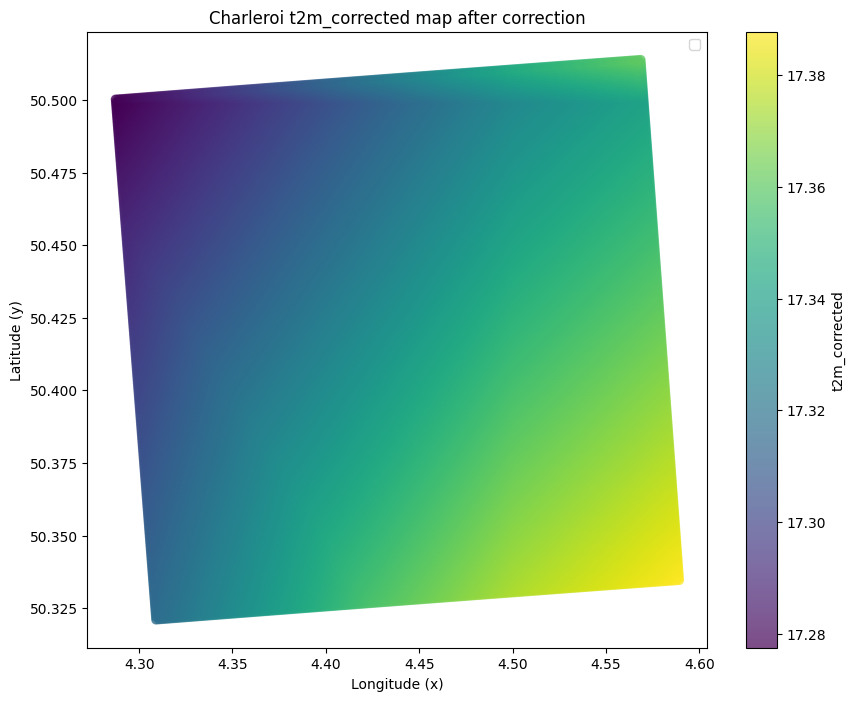

In [17]:
start_time = '2016-07-01 00:00:00'
selected_data = interpolated_era5_df[(interpolated_era5_df['time'] == start_time)][['t2m_corrected','x','y']]
plot_feature(selected_data, 't2m_corrected', city)

### This part is to interpolate the elevation to urbclim coordinate and calculate the tem_diff2 between sea level and elevation

In [18]:
elevation = xr.open_dataset(f'/Users/wangy/Documents/MACS/Thesis/features/{city}/elevation_{city}_UrbClim_2015_01_v1.0.nc')
elevation_df = elevation.to_dataframe().reset_index()
print(elevation_df[:1000])
elevation_df = elevation_df.rename(columns={'__xarray_dataarray_variable__': 'elevation'})
elevation_df = elevation_df[['x','y','elevation']]

# Divide all values in the elevation column by 1000
elevation_df['elevation'] = elevation_df['elevation'] / 1000
print(elevation_df)
elevation_interpolated = interpolate(elevation_df, urbclim_coor, 'elevation')
elevation_interpolated[['tem_diff2']] = elevation_interpolated[['elevation']] / 100*0.6
print(elevation_interpolated)


     band         x          y  spatial_ref  __xarray_dataarray_variable__
0       1  4.287202  50.513763            0                            NaN
1       1  4.287202  50.512619            0                            NaN
2       1  4.287202  50.511476            0                            NaN
3       1  4.287202  50.510333            0                            NaN
4       1  4.287202  50.509190            0                            NaN
..    ...       ...        ...          ...                            ...
995     1  4.292919  50.347987            0                  173857.287063
996     1  4.292919  50.346844            0                  151905.052216
997     1  4.292919  50.345701            0                  129656.320641
998     1  4.292919  50.344558            0                  125687.298002
999     1  4.292919  50.343414            0                  119447.024814

[1000 rows x 5 columns]
              x          y  elevation
0      4.287202  50.513763        NaN

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_31089/3232200303.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


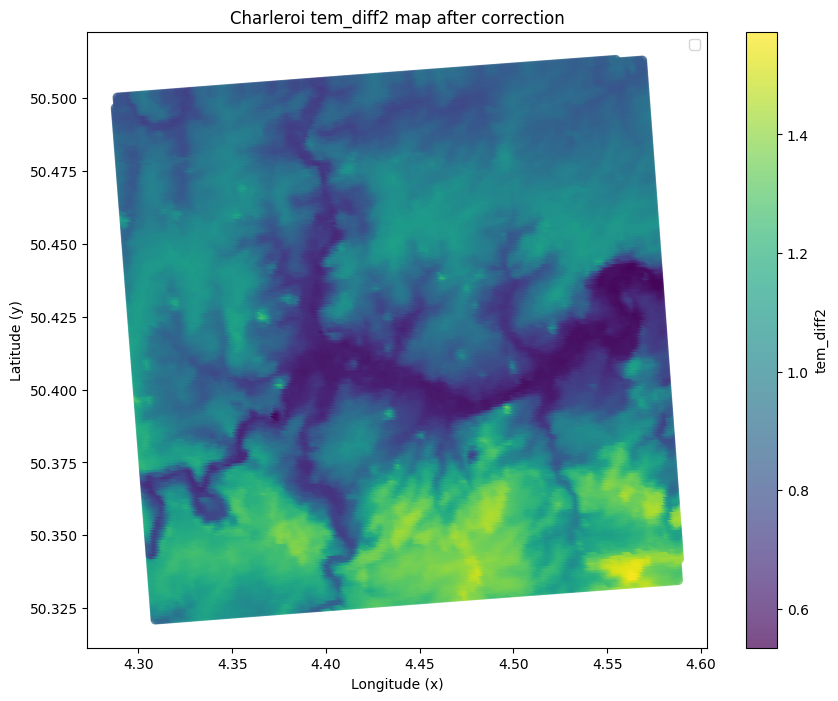

In [19]:
plot_feature(elevation_interpolated, 'tem_diff2', city)

### This part is to traverse the interpolated ERA5 and subtract tem_diff2 from the data at each time point

In [20]:
# era5_t2m_corrected = era5_2015_07_df[['time','t2m_corrected']]
times = len(interpolated_era5_df) // len(elevation_interpolated)
elevation_interpolated_repeat = pd.concat([elevation_interpolated] * times, ignore_index=True)


print(elevation_interpolated_repeat)

                  y         x   elevation  tem_diff2
0         50.321007  4.309057  147.737015   0.886422
1         50.321075  4.310457  145.967479   0.875805
2         50.321148  4.311858  148.024153   0.888145
3         50.321217  4.313258  148.395252   0.890372
4         50.321285  4.314659  148.698251   0.892190
...             ...       ...         ...        ...
30058339  50.513588  4.563002         NaN        NaN
30058340  50.513653  4.564408         NaN        NaN
30058341  50.513720  4.565815         NaN        NaN
30058342  50.513786  4.567221         NaN        NaN
30058343  50.513850  4.568628         NaN        NaN

[30058344 rows x 4 columns]


/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_31089/3232200303.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


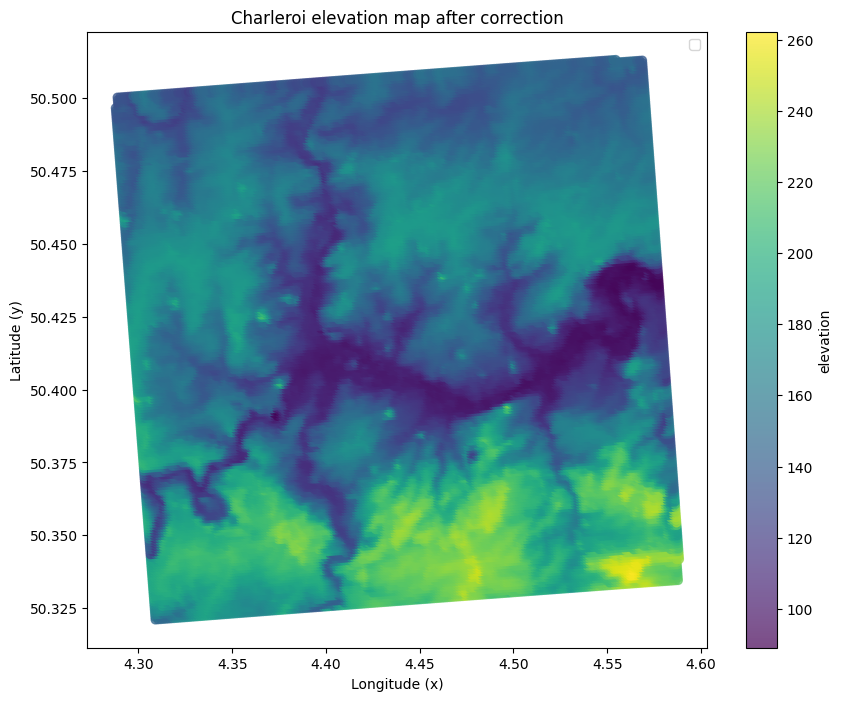

In [21]:
plot_feature(elevation_interpolated_repeat[:40401], 'elevation', city)

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_31089/3232200303.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


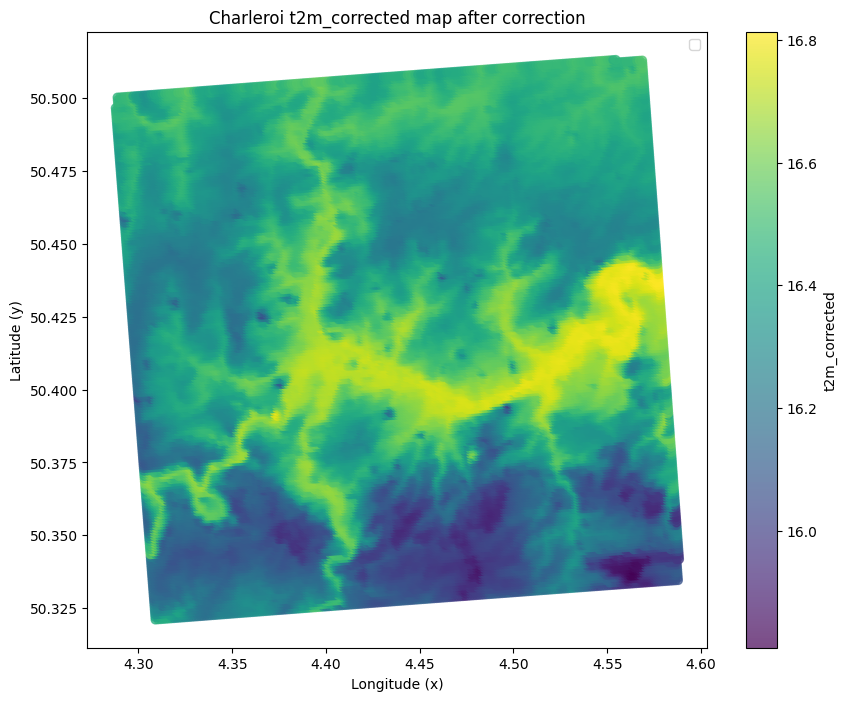

In [22]:
interpolated_era5_df['t2m_corrected'] = interpolated_era5_df['t2m_corrected'] - elevation_interpolated_repeat['tem_diff2']
start_time = '2016-07-01 00:00:00'
selected_data = interpolated_era5_df[(interpolated_era5_df['time'] == start_time)][['t2m_corrected','x','y']]
plot_feature(selected_data, 't2m_corrected', city)

In [23]:
print(interpolated_era5_df)
print(interpolated_era5_df.isna().sum())

                  y         x       u10       v10        t2m         blh  \
0         50.321007  4.309057  1.434845  3.391208  16.268657  283.862443   
1         50.321075  4.310457  1.434657  3.390836  16.268796  283.984284   
2         50.321148  4.311858  1.434472  3.390464  16.268943  284.107035   
3         50.321217  4.313258  1.434284  3.390092  16.269084  284.229058   
4         50.321285  4.314659  1.434097  3.389719  16.269223  284.350961   
...             ...       ...       ...       ...        ...         ...   
30058339  50.513588  4.563002  0.879610  0.753203  13.055943   19.602666   
30058340  50.513653  4.564408  0.881208  0.752577  13.053993   19.610009   
30058341  50.513720  4.565815  0.882804  0.751953  13.052031   19.617392   
30058342  50.513786  4.567221  0.884400  0.751328  13.050075   19.624755   
30058343  50.513850  4.568628  0.885999  0.750701  13.048130   19.632077   

               cape         kx  ssr            str             sp  \
0         80.25720

In [24]:
start_time = '2016-07-01 00:00:00'
end_time = '2016-7-10 23:00:00'
# selected_data = interpolated_era5_df[(interpolated_era5_df['time'] == start_time)]
selected_data = interpolated_era5_df[(interpolated_era5_df['time'] >= start_time) & (interpolated_era5_df['time'] <= end_time)]
print(selected_data)

                 y         x       u10       v10        t2m         blh  \
0        50.321007  4.309057  1.434845  3.391208  16.268657  283.862443   
1        50.321075  4.310457  1.434657  3.390836  16.268796  283.984284   
2        50.321148  4.311858  1.434472  3.390464  16.268943  284.107035   
3        50.321217  4.313258  1.434284  3.390092  16.269084  284.229058   
4        50.321285  4.314659  1.434097  3.389719  16.269223  284.350961   
...            ...       ...       ...       ...        ...         ...   
9696235  50.513588  4.563002  3.333502 -0.466154  18.880176  548.010584   
9696236  50.513653  4.564408  3.329896 -0.466459  18.879714  547.240205   
9696237  50.513720  4.565815  3.326295 -0.466759  18.879253  546.471213   
9696238  50.513786  4.567221  3.322692 -0.467061  18.878792  545.701499   
9696239  50.513850  4.568628  3.319082 -0.467369  18.878329  544.930398   

              cape         kx  ssr           str            sp          sshf  \
0        80.257203 

In [25]:
print(selected_data.isna().sum())

y                   0
x                   0
u10                 0
v10                 0
t2m                 0
blh                 0
cape                0
kx                  0
ssr                 0
str                 0
sp                  0
sshf                0
tcc                 0
tcw                 0
tp                  0
t2m_corrected    5280
time                0
dtype: int64


In [26]:
selected_data.to_csv(f"/Users/wangy/Documents/MACS/Thesis/ERA5_variables/{city}/ERA5_2017_07_01to03_{city}_Corrected_v1.csv")